In [1]:
import face_recognition
import numpy as np
import pickle
import torch
import torch.cuda
import cv2
import os
import dlib
import urllib.request
import bz2
from tqdm import tqdm
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
import uuid

# Qdrant Configuration
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = "video_faces_v3"

# Batch processing configuration
BATCH_SIZE = 4
SKIP_FRAMES = 1
FACE_DETECTION_SIZE = (640, 480)

# Face similarity threshold
FACE_SIMILARITY_THRESHOLD = 0.6

qdrant_client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

def ensure_qdrant_collection():
    try:
        collections = qdrant_client.get_collections()
        collection_exists = any(col.name == COLLECTION_NAME for col in collections.collections)
        
        if collection_exists:
            print(f"[INFO] Collection '{COLLECTION_NAME}' exists.")
            qdrant_client.delete_collection(COLLECTION_NAME)
            collection_exists = False
        
        if not collection_exists:
            print(f"[INFO] Creating Qdrant collection '{COLLECTION_NAME}'...")
            qdrant_client.create_collection(
                collection_name=COLLECTION_NAME,
                vectors_config=VectorParams(
                    size=128,
                    distance=Distance.COSINE
                )
            )
            print(f"[INFO] Collection '{COLLECTION_NAME}' created successfully.")
    except Exception as e:
        print(f"[ERROR] Error managing Qdrant collection: {str(e)}")
        raise
def download_and_extract_model(url, filename):
    """Download and extract the model file if it doesn't exist"""
    if not os.path.exists(filename):
        print(f"[INFO] Downloading {filename}...")
        compressed_file = filename + '.bz2'
        
        # Download the compressed file
        urllib.request.urlretrieve(url, compressed_file)
        
        # Extract the compressed file
        print(f"[INFO] Extracting {filename}...")
        with bz2.BZ2File(compressed_file) as fr, open(filename, 'wb') as fw:
            fw.write(fr.read())
        
        # Remove the compressed file
        os.remove(compressed_file)
        print(f"[INFO] {filename} ready!")
def ensure_models_exist():
    """Ensure all required models are downloaded"""
    models = {
        'mmod_human_face_detector.dat': 'http://dlib.net/files/mmod_human_face_detector.dat.bz2',
        'shape_predictor_68_face_landmarks.dat': 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2',
        'dlib_face_recognition_resnet_model_v1.dat': 'http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2'
    }
    
    for model_file, url in models.items():
        download_and_extract_model(url, model_file)
def batch_save_to_qdrant(batch_results, video_path, fps):
    try:
        points = []
        for frame_num, boxes, encodings in batch_results:
            for box, encoding in zip(boxes, encodings):
                if encoding is None or not isinstance(encoding, np.ndarray):
                    continue

                encoding_list = encoding.tolist()
                if len(encoding_list) != 128:
                    continue

                point_id = str(uuid.uuid4())
                time_in_seconds = frame_num / fps

                metadata = {
                    "video_path": str(video_path),
                    "frame": frame_num,
                    "timestamp": time_in_seconds,
                    "location": [int(x) for x in box]
                }

                points.append(PointStruct(
                    id=point_id,
                    vector=encoding_list,
                    payload=metadata
                ))
        
        if points:
            qdrant_client.upsert(
                collection_name=COLLECTION_NAME,
                points=points
            )
            print(f"[INFO] Successfully saved batch of {len(points)} encodings")

    except Exception as e:
        print(f"[ERROR] Failed to save batch: {str(e)}")
        raise

def process_frame_batch(batch_data):
    frames, frame_numbers, video_path, cnn_face_detector = batch_data
    results = []
    
    for frame, frame_num in zip(frames, frame_numbers):
        try:
            small_frame = cv2.resize(frame, FACE_DETECTION_SIZE)
            rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
            detected_faces = cnn_face_detector(rgb_small_frame)
            
            height_scale = frame.shape[0] / FACE_DETECTION_SIZE[1]
            width_scale = frame.shape[1] / FACE_DETECTION_SIZE[0]
            
            boxes = []
            for face in detected_faces:
                rect = face.rect
                left = int(rect.left() * width_scale)
                top = int(rect.top() * height_scale)
                right = int(rect.right() * width_scale)
                bottom = int(rect.bottom() * height_scale)
                boxes.append((top, right, bottom, left))
            
            encodings = []
            if boxes:
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                encodings = face_recognition.face_encodings(rgb_frame, boxes)
            
            results.append((frame_num, boxes, encodings))
            
        except Exception as e:
            print(f"[ERROR] Error processing frame {frame_num}: {str(e)}")
            continue
    
    return results

def main():
    ensure_qdrant_collection()
    print("[INFO] Checking and downloading required models...")
    ensure_models_exist()
    video_folder = "videos/"
    video_paths = [os.path.join(video_folder, f)
                   for f in os.listdir(video_folder)
                   if f.endswith(('.mp4', '.avi', '.mov'))]

    if not video_paths:
        print("[ERROR] No video files found in the videos folder!")
        return

    for video_path in video_paths:
        print(f"[INFO] Processing video: {video_path}")
        video_capture = cv2.VideoCapture(video_path)

        if not video_capture.isOpened():
            print(f"[ERROR] Could not open video file: {video_path}")
            continue

        total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = video_capture.get(cv2.CAP_PROP_FPS)
        frame_count = 0

        frames_batch = []
        frame_numbers_batch = []

        with tqdm(total=total_frames, desc="Processing frames") as pbar:
            while True:
                ret, frame = video_capture.read()
                if not ret:
                    break

                frame_count += 1
                frames_batch.append(frame)
                frame_numbers_batch.append(frame_count)

                if len(frames_batch) >= BATCH_SIZE:
                    batch_data = (frames_batch, frame_numbers_batch, video_path, cnn_face_detector)
                    results = process_frame_batch(batch_data)
                    batch_save_to_qdrant(results, video_path, fps)

                    frames_batch = []
                    frame_numbers_batch = []

                    pbar.update(BATCH_SIZE)

            if frames_batch:
                batch_data = (frames_batch, frame_numbers_batch, video_path, cnn_face_detector)
                results = process_frame_batch(batch_data)
                batch_save_to_qdrant(results, video_path, fps)
                pbar.update(len(frames_batch))

        video_capture.release()

    print("[INFO] All videos processed and data saved to Qdrant.")

if __name__ == "__main__":
    print("[INFO] Loading face detection model...")
    cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')

    if torch.cuda.is_available():
        print("[INFO] Using CUDA for face detection")
        dlib.DLIB_USE_CUDA = True

    main()

[INFO] Loading face detection model...
[INFO] Using CUDA for face detection
[INFO] Collection 'video_faces_v3' exists.
[INFO] Creating Qdrant collection 'video_faces_v3'...
[INFO] Collection 'video_faces_v3' created successfully.
[INFO] Checking and downloading required models...
[INFO] Processing video: videos/video2.mp4


Processing frames:   2%|▏         | 4/194 [00:37<29:33,  9.33s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:   4%|▍         | 8/194 [01:13<28:29,  9.19s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:   6%|▌         | 12/194 [01:49<27:28,  9.06s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:   8%|▊         | 16/194 [02:25<26:45,  9.02s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  10%|█         | 20/194 [03:01<26:06,  9.00s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  12%|█▏        | 24/194 [03:37<25:29,  9.00s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  14%|█▍        | 28/194 [04:12<24:52,  8.99s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  16%|█▋        | 32/194 [04:49<24:29,  9.07s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  19%|█▊        | 36/194 [05:27<24:07,  9.16s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  21%|██        | 40/194 [06:03<23:29,  9.15s/it]

[INFO] Successfully saved batch of 3 encodings


Processing frames:  23%|██▎       | 44/194 [06:38<22:34,  9.03s/it]

[INFO] Successfully saved batch of 1 encodings


Processing frames:  25%|██▍       | 48/194 [07:15<22:06,  9.09s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  27%|██▋       | 52/194 [07:52<21:34,  9.12s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  29%|██▉       | 56/194 [08:29<20:58,  9.12s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  31%|███       | 60/194 [09:05<20:21,  9.11s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  33%|███▎      | 64/194 [09:42<19:46,  9.13s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  35%|███▌      | 68/194 [10:17<19:03,  9.08s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  37%|███▋      | 72/194 [10:53<18:23,  9.05s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  39%|███▉      | 76/194 [11:29<17:44,  9.02s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  41%|████      | 80/194 [12:05<17:06,  9.00s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  43%|████▎     | 84/194 [12:41<16:30,  9.00s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  45%|████▌     | 88/194 [13:17<15:54,  9.01s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  47%|████▋     | 92/194 [13:53<15:18,  9.01s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  49%|████▉     | 96/194 [14:29<14:42,  9.01s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  52%|█████▏    | 100/194 [15:04<13:59,  8.93s/it]

[INFO] Successfully saved batch of 2 encodings


Processing frames:  62%|██████▏   | 120/194 [17:52<10:33,  8.56s/it]

[INFO] Successfully saved batch of 2 encodings


Processing frames:  64%|██████▍   | 124/194 [18:28<10:08,  8.69s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  66%|██████▌   | 128/194 [19:04<09:39,  8.77s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  68%|██████▊   | 132/194 [19:40<09:08,  8.84s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  70%|███████   | 136/194 [20:15<08:31,  8.81s/it]

[INFO] Successfully saved batch of 2 encodings


Processing frames:  72%|███████▏  | 140/194 [20:50<07:54,  8.78s/it]

[INFO] Successfully saved batch of 2 encodings


Processing frames:  74%|███████▍  | 144/194 [21:25<07:20,  8.81s/it]

[INFO] Successfully saved batch of 3 encodings


Processing frames:  76%|███████▋  | 148/194 [22:00<06:42,  8.74s/it]

[INFO] Successfully saved batch of 1 encodings


Processing frames:  78%|███████▊  | 152/194 [22:36<06:09,  8.80s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  80%|████████  | 156/194 [23:11<05:36,  8.85s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  82%|████████▏ | 160/194 [23:47<05:02,  8.89s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  85%|████████▍ | 164/194 [24:23<04:27,  8.91s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  87%|████████▋ | 168/194 [24:59<03:52,  8.93s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  89%|████████▊ | 172/194 [25:35<03:16,  8.95s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  91%|█████████ | 176/194 [26:11<02:41,  8.97s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  93%|█████████▎| 180/194 [26:47<02:05,  8.96s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  95%|█████████▍| 184/194 [27:23<01:29,  8.97s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  97%|█████████▋| 188/194 [27:59<00:53,  8.97s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames:  99%|█████████▉| 192/194 [28:35<00:17,  8.97s/it]

[INFO] Successfully saved batch of 4 encodings


Processing frames: 100%|██████████| 194/194 [28:53<00:00,  8.94s/it]

[INFO] Successfully saved batch of 2 encodings
[INFO] All videos processed and data saved to Qdrant.


[INFO] Fetching data from Qdrant...
[INFO] Successfully fetched 162 valid encodings
[INFO] Clustering embeddings...
[INFO] Number of clusters found: 2
[INFO] Generating summary images...


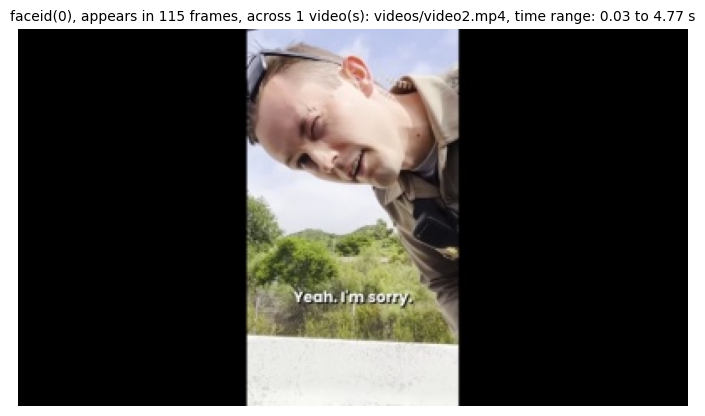

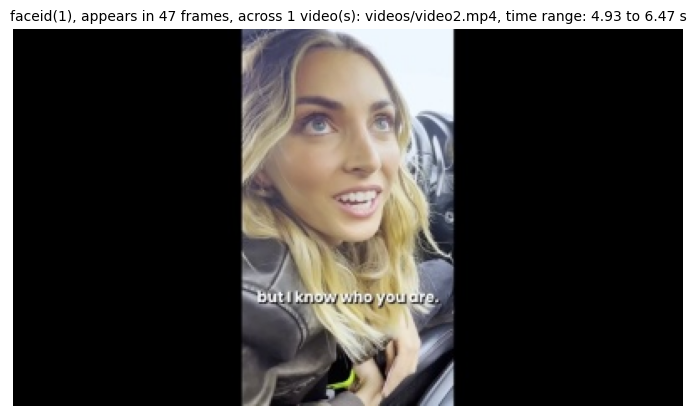

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from qdrant_client import QdrantClient
import numpy as np
import cv2
import os
import json

# Qdrant Configuration
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
COLLECTION_NAME = "video_faces_v3"

# Clustering parameters
DBSCAN_EPS = 0.3  # Adjust based on your dataset characteristics
DBSCAN_MIN_SAMPLES = 3  # Adjust as needed

qdrant_client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, set):
        return list(obj)
    return obj

def fetch_data_from_qdrant():
    print("[INFO] Fetching data from Qdrant...")
    encodings = []
    data = []
    next_offset = None

    try:
        while True:
            response = qdrant_client.scroll(
                collection_name=COLLECTION_NAME,
                with_payload=True,
                with_vectors=True,
                limit=10000,
                offset=next_offset
            )
            
            for point in response[0]:
                if hasattr(point, 'vector') and point.vector and len(point.vector) == 128:
                    encodings.append(point.vector)
                    data.append(point.payload)
                
            next_offset = response[1]
            if next_offset is None:
                break

        print(f"[INFO] Successfully fetched {len(encodings)} valid encodings")
        return encodings, data

    except Exception as e:
        print(f"[ERROR] Error fetching data from Qdrant: {str(e)}")
        return [], []

def cluster_encodings(encodings):
    print("[INFO] Clustering embeddings...")
    clt = DBSCAN(
        eps=DBSCAN_EPS,
        min_samples=DBSCAN_MIN_SAMPLES,
        metric='euclidean',
        n_jobs=-1
    )
    clt.fit(encodings)
    labels = clt.labels_
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[INFO] Number of clusters found: {num_clusters}")
    return labels

def process_clustered_faces(labels, data):
    """Process clustered face data and prepare summaries."""
    face_appearance = {}

    for i, label in enumerate(labels):
        if label == -1:
            continue

        payload = data[i]
        video_path = payload["video_path"]
        frame_num = payload["frame"]
        timestamp = payload.get("timestamp", frame_num)

        if label not in face_appearance:
            face_appearance[label] = {
                "video_path": video_path,
                "start_time": float('inf'),
                "end_time": -float('inf'),
                "start_frame": float('inf'),
                "end_frame": -float('inf'),
                "frames": [],
                "num_frames": 0,
                "videos": set(),
                "locations": []
            }

        face_appearance[label]["num_frames"] += 1
        face_appearance[label]["videos"].add(video_path)
        face_appearance[label]["start_time"] = min(face_appearance[label]["start_time"], timestamp)
        face_appearance[label]["end_time"] = max(face_appearance[label]["end_time"], timestamp)
        face_appearance[label]["start_frame"] = min(face_appearance[label]["start_frame"], frame_num)
        face_appearance[label]["end_frame"] = max(face_appearance[label]["end_frame"], frame_num)
        face_appearance[label]["frames"].append(frame_num)
        face_appearance[label]["locations"].append(payload.get("location", []))

    return face_appearance

def create_summary_images(face_appearance):
    """Generate summary images and display them with formatted text."""
    print("[INFO] Generating summary images...")

    for face_id, info in sorted(face_appearance.items()):
        video_path = info["video_path"]

        if not os.path.exists(video_path):
            print(f"[WARNING] Video file {video_path} not found. Skipping Face ID {face_id}.")
            continue

        cap = cv2.VideoCapture(video_path)
        median_frame_index = info["frames"][len(info["frames"]) // 2]
        cap.set(cv2.CAP_PROP_POS_FRAMES, median_frame_index)
        ret, frame = cap.read()

        if ret:
            # Instead of cropping, resize the full frame to a consistent size
            new_width = 400
            aspect_ratio = frame.shape[1] / frame.shape[0]
            new_height = int(new_width / aspect_ratio)
            frame_resized = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)

            os.makedirs("face_summaries", exist_ok=True)
            face_summary_path = f"face_summaries/face_id_{face_id}.jpg"
            cv2.imwrite(face_summary_path, frame_resized)

            video_filenames = ", ".join(info["videos"])
            formatted_text = (f"faceid({face_id}), appears in "
                              f"{info['num_frames']} frames, across {len(info['videos'])} video(s): "
                              f"{video_filenames}, time range: {info['start_time']:.2f} to {info['end_time']:.2f} s")

            # Display image with its corresponding text
            img = mpimg.imread(face_summary_path)
            plt.figure(figsize=(7, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.title(formatted_text, fontsize=10)
            plt.tight_layout()
            plt.show()

        cap.release()

def main():
    encodings, data = fetch_data_from_qdrant()

    if len(encodings) == 0:
        print("[ERROR] No valid encodings found in Qdrant. Exiting.")
        return

    labels = cluster_encodings(encodings)
    face_appearance = process_clustered_faces(labels, data)
    create_summary_images(face_appearance)

if __name__ == "__main__":
    main()

[DEBUG] Loaded image shape: (883, 695, 3)
[INFO] Fetching all points from Qdrant...
[INFO] Total points in collection: 162
faceid(0), appears in 115 frames, across 1 video(s): videos/video2.mp4, time range: 0.03333333333333333 to 4.766666666666667 s


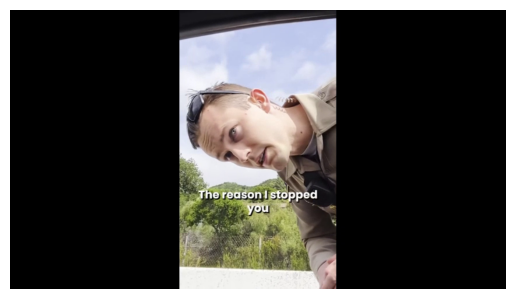

In [5]:
import os
import numpy as np
from qdrant_client import QdrantClient
import face_recognition
import matplotlib.pyplot as plt
import cv2

class QdrantFaceDebugger:
    def __init__(self):
        # Qdrant Configuration
        self.QDRANT_URL = os.getenv("QDRANT_URL")
        self.QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
        self.COLLECTION_NAME = "video_faces_v2"

        # Initialize Qdrant Client
        self.qdrant_client = QdrantClient(
            url=self.QDRANT_URL,
            api_key=self.QDRANT_API_KEY
        )

    def debug_qdrant_collection(self, query_image_path):
    # Load and encode query image
        try:
            query_image = face_recognition.load_image_file(query_image_path)
            print(f"[DEBUG] Loaded image shape: {query_image.shape}")
        except Exception as e:
            print(f"[ERROR] Failed to load image: {e}")
            return

        query_face_locations = face_recognition.face_locations(query_image)
        query_encodings = face_recognition.face_encodings(query_image, query_face_locations)

        if not query_encodings:
            print("[ERROR] No faces detected in query image")
            return

    # rest of your code...

        query_encoding = query_encodings[0]

        # Fetch all points from Qdrant
        all_points = []
        next_offset = None

        print("[INFO] Fetching all points from Qdrant...")
        while True:
            response = self.qdrant_client.scroll(
                collection_name=self.COLLECTION_NAME,
                with_payload=True,
                with_vectors=True,
                limit=1000,
                offset=next_offset
            )

            all_points.extend(response[0])
            next_offset = response[1]

            if next_offset is None:
                break

        print(f"[INFO] Total points in collection: {len(all_points)}")

        if len(all_points) == 0:
            print("[ERROR] No points found in the collection. Cannot proceed with debugging.")
            return

        # Configure similarity threshold
        threshold = 0.6

        # Compute similarities above threshold
        similarities = []
        for point in all_points:
            if not hasattr(point, 'vector') or not point.vector:
                continue

            # Compute Euclidean distance
            distance = np.linalg.norm(query_encoding - np.array(point.vector))
            similarity = 1 / (1 + distance)
            
            if similarity > threshold:
                similarities.append({
                    'similarity': similarity,
                    'video_path': point.payload.get('video_path', 'Unknown'),
                    'frame': point.payload.get('frame', 'Unknown'),
                    'timestamp': point.payload.get('timestamp', 'Unknown')
                })

        # Group by video
        video_summaries = {}
        for match in similarities:
            video_path = match['video_path']
            if video_path not in video_summaries:
                video_summaries[video_path] = {
                    'frames': [],
                    'timestamps': []
                }
            video_summaries[video_path]['frames'].append(match['frame'])
            video_summaries[video_path]['timestamps'].append(match['timestamp'])

        if not video_summaries:
            print("[ERROR] No matches found above threshold.")
            return

        best_video = max(video_summaries, key=lambda x: len(video_summaries[x]['frames']))
        frames = video_summaries[best_video]['frames']
        timestamps = video_summaries[best_video]['timestamps']

        print(f"faceid(0), appears in {len(frames)} frames, across 1 video(s): {best_video}, time range: {min(timestamps)} to {max(timestamps)} s")

        # Show frame from best match
        self.show_frame_from_video(best_video, frames[0])

    def show_frame_from_video(self, video_path, frame_number):
        """
        Show a specific frame from a video.
        """
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        cap.release()

        if ret:
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        else:
            print(f"[ERROR] Could not retrieve frame {frame_number} from video {video_path}")

def main():
    # Path to your screenshot
    query_image_path = 'C:/Greg-Galvin-Unique-Faces-and-Object-Identification/Screenshot2.png'
    
    # Initialize debugger
    debugger = QdrantFaceDebugger()
    
    # Run comprehensive debug
    debugger.debug_qdrant_collection(query_image_path)

if __name__ == "__main__":
    main()